# <ins> Análisis de datos de accidentes viales </ins>

## 1- Importando el dataset

### _Se importa el dataset con Pandas y se definen los nombres de las columnas, para poder referenciarlas posteriormente._

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


pd.set_option('display.max_columns', None)

#Importamos solamente los atributos que nos interesa analizar.
data_frame = pd.read_csv("Accidente.csv", header=0 ,usecols=["Severity","Junction", "Stop", "Traffic_Signal", "Sunrise_Sunset"])

#Definimos la semilla que se utilizará a lo largo del proyecto.
random_state=150

## 2- Data Processing.

### _Se aplica One-Hot-Encoding para tratar los datos categóricos de forma adecuada para los modelos._

In [2]:
#Columna "Junction"
data_frame_dummies_junction = pd.get_dummies(data_frame['Junction'])
data_frame_dummies_junction = data_frame_dummies_junction.rename(columns=lambda s: "Junction_ {}".format(s))
data_frame = data_frame.drop(['Junction'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_junction)

#Columna "Stop"
data_frame_dummies_stop = pd.get_dummies(data_frame['Stop'])
data_frame_dummies_stop = data_frame_dummies_stop.rename(columns=lambda s: "Stop_{}".format(s))
data_frame = data_frame.drop(['Stop'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_stop)

#Columna "Traffic_Signal"
data_frame_dummies_traffic_signal = pd.get_dummies(data_frame['Traffic_Signal'])
data_frame_dummies_traffic_signal = data_frame_dummies_traffic_signal.rename(columns=lambda s: "Traffic_Signal_{}".format(s))
data_frame = data_frame.drop(['Traffic_Signal'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_traffic_signal)

#Columna "Sunrise_Sunset"
data_frame_dummies_sunrise_sunset = pd.get_dummies(data_frame['Sunrise_Sunset'])
data_frame_dummies_sunrise_sunset = data_frame_dummies_sunrise_sunset.rename(columns=lambda s: "Sunrise_Sunset_" + s)
data_frame = data_frame.drop(['Sunrise_Sunset'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_sunrise_sunset)


data_frame.head(5)

,Severity,Junction_ False,Junction_ True,Stop_False,Stop_True,Traffic_Signal_False,Traffic_Signal_True,Sunrise_Sunset_Day,Sunrise_Sunset_Night
0,3,1,0,1,0,1,0,0,1
1,2,1,0,1,0,1,0,0,1
2,2,1,0,1,0,0,1,0,1
3,3,1,0,1,0,1,0,0,1
4,2,1,0,1,0,0,1,1,0


## 3- Aplicación de Modelos - Linear SVC.

### _3.1- Se divide el dataset en x (datos sin el objetivo) e y (objetivo)._

In [3]:
"""data_frame_sample = data_frame[["Severity","Junction_ False", "Junction_ True", "Stop_False", "Stop_True",
 "Traffic_Signal_False", "Traffic_Signal_True", "Sunrise_Sunset_Day", "Sunrise_Sunset_Night"]]
y_sample = data_frame_sample["Severity"]
x_sample = data_frame_sample.drop("Severity", axis=1)"""

'data_frame_sample = data_frame[["Severity","Junction_ False", "Junction_ True", "Stop_False", "Stop_True",\n "Traffic_Signal_False", "Traffic_Signal_True", "Sunrise_Sunset_Day", "Sunrise_Sunset_Night"]]\ny_sample = data_frame_sample["Severity"]\nx_sample = data_frame_sample.drop("Severity", axis=1)'

### _3.2- Se aplica Grid Search para conseguir el parámetro de C que mejor ajusta al modelo._

In [14]:
#parameters = [{"C": [1, 10, 100]}]
parameters = [{"kernel": ["linear", "rbf", "sigmoid"], "C": [.2, .5, .8, 1.]}, {"kernel": ["poly"], "C": [.2, .5, .8, 1.], "degree": [2, 3, 4]}]

#modelSVC = LinearSVC(verbose=5, random_state=random_state)
modelSVC = svm.SVC(verbose=5, random_state=random_state)
sample = data_frame.sample(5_000, random_state=random_state)
y_sample = sample["Severity"]
x_sample = sample.drop("Severity", axis=1)

grid = GridSearchCV(modelSVC, parameters, verbose=5, n_jobs=-1)

grid.fit(x_sample, y_sample)

print("Mejor valor de C:")
print(grid.best_params_)
print("Train score:", grid.score(x_sample, y_sample))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LibSVM]Mejor valor de C:
{'C': 0.5, 'kernel': 'rbf'}
Train score: 0.6714


### _3.3- Una vez conseguido el mejor valor de C, se lo utiliza para entrenar al modelo con el mismo._

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(x_sample, y_sample, test_size=0.2)
linear_svc = svm.SVC(**grid.best_params_, random_state=random_state)
#linear_svc = LinearSVC(C=100, random_state=random_state)
linear_svc.fit(xtrain, ytrain)

print("Train score:", linear_svc.score(xtrain, ytrain))
print("Test score:", linear_svc.score(xtest, ytest))

Train score: 0.66775
Test score: 0.686


### _3.4- Se predicen los resultados de Severity de acuerdo a los datos de testing, y se proyecta su resultado en una matriz de confusión._

YPRED MAX: 3
YPRED MIN: 2


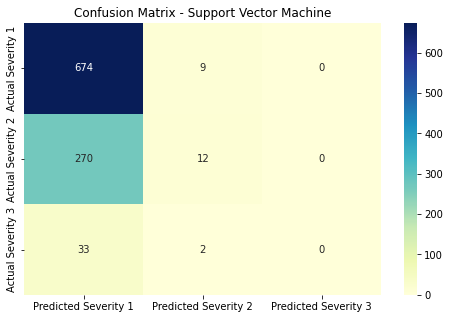

In [20]:
y_pred = linear_svc.predict(xtest)
confmat = confusion_matrix(y_true=ytest, y_pred=y_pred)

print("YPRED MAX: {}".format(np.max(y_pred)))
print("YPRED MIN: {}".format(np.min(y_pred)))

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()